In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from model.resnet import ResNet
from utils import data_config
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

for gpu in physical_devices:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [3]:
# define the total number of epochs to train for along with the
# initial learning rate and batch size
NUM_EPOCHS = 20
INIT_LR = 1e-1
BS = 32

In [4]:
def poly_decay(epoch):
	# initialize the maximum number of epochs, base learning rate,
	# and power of the polynomial
	maxEpochs = NUM_EPOCHS
	baseLR = INIT_LR
	power = 1.0

	# compute the new learning rate based on polynomial decay
	alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power

	# return the new learning rate
	return alpha

In [5]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(data_config.TRAIN_PATH)))
totalVal = len(list(paths.list_images(data_config.VAL_PATH)))
totalTest = len(list(paths.list_images(data_config.TEST_PATH)))

In [6]:
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.05,
	horizontal_flip=True,
	fill_mode="nearest")

In [7]:
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [8]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	data_config.TRAIN_PATH,
	class_mode="binary",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	data_config.VAL_PATH,
	class_mode="binary",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 6556 images belonging to 2 classes.
Found 607 images belonging to 2 classes.


In [9]:
# initialize the testing generator
testGen = valAug.flow_from_directory(
	data_config.TEST_PATH,
	class_mode="binary",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 1520 images belonging to 2 classes.


In [10]:
# initialize our ResNet model and compile it
model = ResNet.build(64, 64, 3, 2, (3, 4, 6), (64, 128, 256, 512), reg=0.0005)
opt = SGD(lr=INIT_LR, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.reset_metrics()

In [11]:
# define our set of callbacks and fit the model
callbacks = [LearningRateScheduler(poly_decay)]
H = model.fit(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	epochs=NUM_EPOCHS,
	callbacks=callbacks)

Epoch 1/20
204/204 [==============================] - 480s 2s/step - loss: 1.0939 - accuracy: 0.7231 - val_loss: 1.0936 - val_accuracy: 0.7292
Epoch 2/20
204/204 [==============================] - 470s 2s/step - loss: 0.9719 - accuracy: 0.7538 - val_loss: 1.0331 - val_accuracy: 0.7309
Epoch 3/20
204/204 [==============================] - 460s 2s/step - loss: 0.9391 - accuracy: 0.7597 - val_loss: 1.0086 - val_accuracy: 0.7101
Epoch 4/20
204/204 [==============================] - 457s 2s/step - loss: 0.9056 - accuracy: 0.7623 - val_loss: 0.9794 - val_accuracy: 0.7257
Epoch 5/20
204/204 [==============================] - 448s 2s/step - loss: 0.8638 - accuracy: 0.7748 - val_loss: 0.9007 - val_accuracy: 0.7465
Epoch 6/20
204/204 [==============================] - 448s 2s/step - loss: 0.8266 - accuracy: 0.7851 - val_loss: 0.8523 - val_accuracy: 0.7639
Epoch 7/20
204/204 [==============================] - 447s 2s/step - loss: 0.8027 - accuracy: 0.7872 - val_loss: 0.8637 - val_accuracy: 0.7622

[INFO] evaluating network...

                  precision    recall  f1-score   support

     benign_fold       0.82      0.89      0.86      1084
malignant_images       0.66      0.52      0.58       436

        accuracy                           0.78      1520
       macro avg       0.74      0.71      0.72      1520
    weighted avg       0.78      0.78      0.78      1520



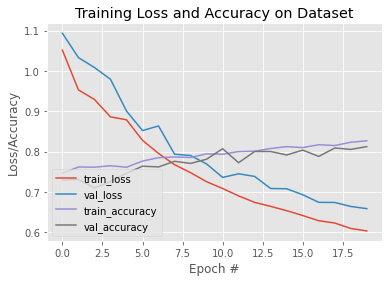

In [12]:
# reset the testing generator and then use our trained model to
# make predictions on the data
model.save('ResNet_ISIC_wit_Synthetic.h5')

print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict(testGen, steps=(totalTest // BS) + 1)
 
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.where(predIdxs>0.5,1,0)
print()

# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))

# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot_3")